In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import numpy as np
from matplotlib import pyplot
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is", device)

device is cuda:0


In [2]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.Sigmoid()

        # input: 100      
        self.fc1 = nn.Linear(in_features=100, out_features=128)    
        self.fc2 = nn.Linear(in_features=128, out_features=784)

        self.sig = nn.Sigmoid()


    
    def forward(self, x):
        x = self.fc1(x) #100->128
        x = self.act(x) #128->128
        x = self.fc2(x) #128->784
        x = self.sig(x) #784->784 (28x28)
        return x

class Generator_loss(nn.Module):
    def __init__(self):
        super(Generator_loss, self).__init__()

    def forward(self, output_fake):
        loss = -torch.log(output_fake)
        return loss.mean()
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.ReLU()

        # input: 784     
        self.fc1 = nn.Linear(in_features=784, out_features=128) 
        self.fc2 = nn.Linear(in_features=128, out_features=1)

        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x) #784->128
        x = self.act(x) #128->128
        x_logits = self.fc2(x) #128->1
        x_prob = self.sig(x_logits) #1->1
        return x_prob, x_logits
    
class Discriminator_loss(nn.Module):
    def __init__(self):
        super(Discriminator_loss, self).__init__()

    def forward(self, output_real, output_fake):
        loss = -(torch.log(output_real)+torch.log(1-output_fake))
        return loss.mean()

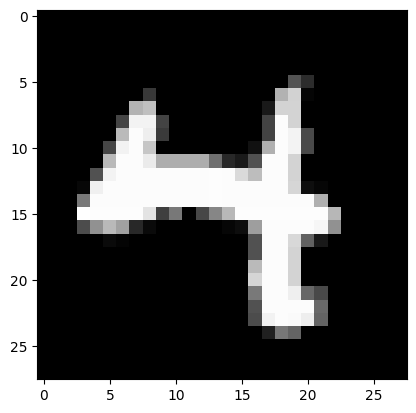

In [3]:
# Define the mini-batch size
batch_size = 100

# Download the dataset and create the dataloaders
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())

# Dataset is split 8:2
train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size
mnist_train, mnist_val = random_split(mnist_train, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=False)

to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)

def plot_digit(data):
    data = data.view(28, 28)
    plt.imshow(data, cmap="gray")

    plt.show()

images, labels = next(iter(train_loader))
plot_digit(images[0])

In [4]:
def train_models(model_d, criterion_d, optimizer_d, scheduler_d, model_g, criterion_g, optimizer_g, scheduler_g, epochs, train_loader, k, batch_sz):
    it = iter(train_loader)
    for epoch in range(epochs):
          
        #Train Discriminator 
        for batch_nr in range(k):
            try:
                images,_ = next(it)
            except:
                it = iter(train_loader)
                images,_ = next(it)          
            _, out_real = model_d(torch.flatten(images,start_dim=1).to(device))
            _, out_fake = model_d(model_g(torch.rand(batch_sz,1,100).to(device)))
            optimizer_d.zero_grad()
            loss_d_real = criterion_d(out_real,torch.ones_like(out_real)).to(device)
            loss_d_fake = criterion_d(out_fake,torch.zeros_like(out_fake)).to(device)
            loss_d = loss_d_real+loss_d_fake
            loss_d.backward()
            optimizer_d.step()
            scheduler_d.step()

        #Train Generator
        _, out_fake = model_d(model_g(torch.rand(batch_sz,1,100).to(device)))
        optimizer_g.zero_grad()
        loss_g = criterion_g(out_fake,torch.ones_like(out_fake)).to(device)
        loss_g.backward()
        optimizer_g.step()
        scheduler_g.step()
        
        
        
        if epoch%50==0:
            print("Epoch:",epoch)  
            print("loss_g:",loss_g.item(),"\tloss_d:",loss_d.item())
        if epoch%500==0:
            disp = model_g(torch.rand(batch_sz,1,100).to(device))
            plot_digit(torch.reshape(disp[0,0,:],(28,28)).detach().cpu())

Epoch: 0
loss_g: 1.0088462829589844 	loss_d: 1.1813666820526123


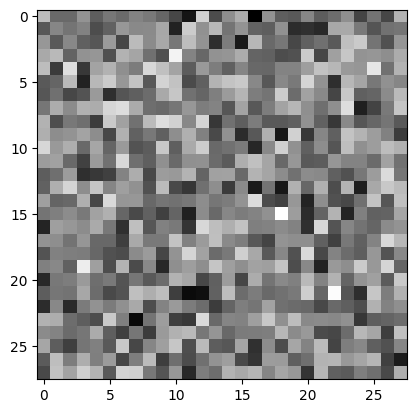

Epoch: 50
loss_g: 4.827827453613281 	loss_d: 0.04342425987124443
Epoch: 100
loss_g: 5.04677152633667 	loss_d: 0.01931620016694069
Epoch: 150
loss_g: 4.674452781677246 	loss_d: 0.03797706961631775
Epoch: 200
loss_g: 4.073502540588379 	loss_d: 0.050229549407958984
Epoch: 250
loss_g: 3.3294386863708496 	loss_d: 0.141241654753685
Epoch: 300
loss_g: 3.0503625869750977 	loss_d: 0.17076128721237183
Epoch: 350
loss_g: 2.8123257160186768 	loss_d: 0.18714122474193573
Epoch: 400
loss_g: 2.8345654010772705 	loss_d: 0.18726113438606262
Epoch: 450
loss_g: 3.1103367805480957 	loss_d: 0.12419848889112473
Epoch: 500
loss_g: 2.941864013671875 	loss_d: 0.13754667341709137


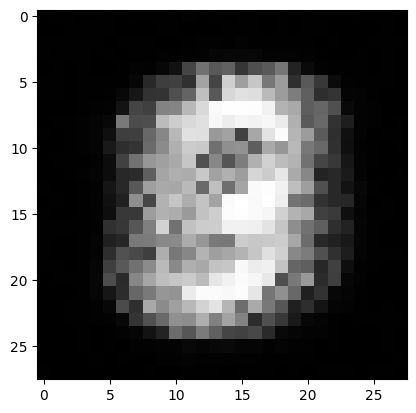

Epoch: 550
loss_g: 3.1095941066741943 	loss_d: 0.12120291590690613
Epoch: 600
loss_g: 3.060533285140991 	loss_d: 0.11307669430971146
Epoch: 650
loss_g: 2.859334945678711 	loss_d: 0.13426260650157928
Epoch: 700
loss_g: 2.2039499282836914 	loss_d: 0.23300506174564362
Epoch: 750
loss_g: 1.572994351387024 	loss_d: 0.398644357919693
Epoch: 800
loss_g: 1.6879291534423828 	loss_d: 0.30468234419822693
Epoch: 850
loss_g: 2.0736465454101562 	loss_d: 0.1945463865995407
Epoch: 900
loss_g: 2.496877670288086 	loss_d: 0.11662665754556656
Epoch: 950
loss_g: 2.6444244384765625 	loss_d: 0.09393234550952911
Epoch: 1000
loss_g: 3.1902718544006348 	loss_d: 0.06542523205280304


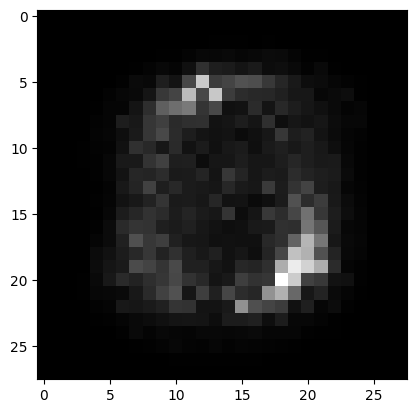

Epoch: 1050
loss_g: 2.954193592071533 	loss_d: 0.07936117798089981
Epoch: 1100
loss_g: 3.309983253479004 	loss_d: 0.053513623774051666
Epoch: 1150
loss_g: 3.029924154281616 	loss_d: 0.07352438569068909
Epoch: 1200
loss_g: 3.0650553703308105 	loss_d: 0.08467632532119751
Epoch: 1250
loss_g: 3.1428136825561523 	loss_d: 0.08338047564029694
Epoch: 1300
loss_g: 3.4396727085113525 	loss_d: 0.06763342022895813
Epoch: 1350
loss_g: 3.3076565265655518 	loss_d: 0.10607536137104034
Epoch: 1400
loss_g: 3.6134212017059326 	loss_d: 0.08368387818336487
Epoch: 1450
loss_g: 3.605440855026245 	loss_d: 0.06184161826968193
Epoch: 1500
loss_g: 3.4617302417755127 	loss_d: 0.07571344077587128


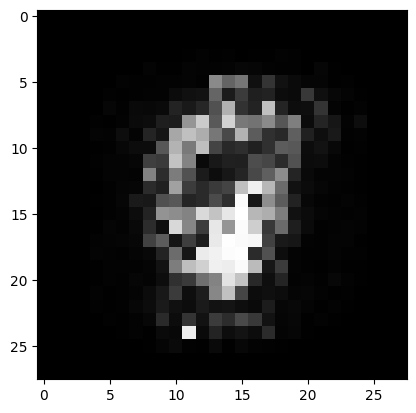

Epoch: 1550
loss_g: 3.8454649448394775 	loss_d: 0.05088656395673752
Epoch: 1600
loss_g: 3.825011730194092 	loss_d: 0.07208359241485596
Epoch: 1650
loss_g: 3.586867570877075 	loss_d: 0.10696535557508469
Epoch: 1700
loss_g: 3.761256217956543 	loss_d: 0.054616622626781464
Epoch: 1750
loss_g: 3.5466854572296143 	loss_d: 0.08712591230869293
Epoch: 1800
loss_g: 3.847109794616699 	loss_d: 0.06444832682609558
Epoch: 1850
loss_g: 3.987375497817993 	loss_d: 0.06504955887794495
Epoch: 1900
loss_g: 3.627140998840332 	loss_d: 0.0569591298699379
Epoch: 1950
loss_g: 3.806452512741089 	loss_d: 0.06229709833860397
Epoch: 2000
loss_g: 3.780885934829712 	loss_d: 0.06514371931552887


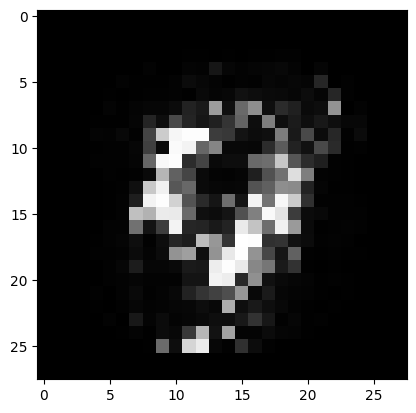

Epoch: 2050
loss_g: 3.926361560821533 	loss_d: 0.038196779787540436
Epoch: 2100
loss_g: 4.264103412628174 	loss_d: 0.05010820925235748
Epoch: 2150
loss_g: 4.0492730140686035 	loss_d: 0.03313497081398964
Epoch: 2200
loss_g: 3.81715989112854 	loss_d: 0.0584639310836792
Epoch: 2250
loss_g: 3.817040205001831 	loss_d: 0.09300099313259125
Epoch: 2300
loss_g: 3.7763466835021973 	loss_d: 0.05296814441680908
Epoch: 2350
loss_g: 3.8262810707092285 	loss_d: 0.04664086923003197
Epoch: 2400
loss_g: 3.8391101360321045 	loss_d: 0.06674482673406601
Epoch: 2450
loss_g: 3.7194783687591553 	loss_d: 0.07442709803581238
Epoch: 2500
loss_g: 3.933128595352173 	loss_d: 0.09669781476259232


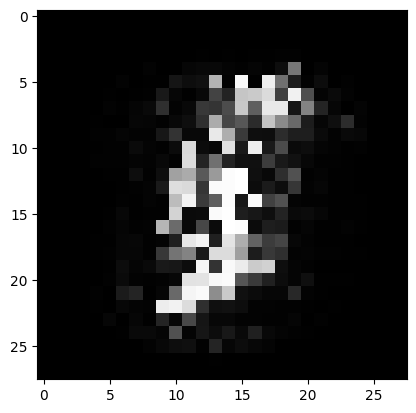

Epoch: 2550
loss_g: 3.811739206314087 	loss_d: 0.03770039230585098
Epoch: 2600
loss_g: 3.9044294357299805 	loss_d: 0.03886782377958298
Epoch: 2650
loss_g: 3.915611982345581 	loss_d: 0.053887687623500824
Epoch: 2700
loss_g: 4.183257102966309 	loss_d: 0.028972748667001724
Epoch: 2750
loss_g: 4.238314151763916 	loss_d: 0.03778887167572975
Epoch: 2800
loss_g: 3.798119306564331 	loss_d: 0.04708138108253479
Epoch: 2850
loss_g: 3.807401657104492 	loss_d: 0.06468722969293594
Epoch: 2900
loss_g: 4.03607702255249 	loss_d: 0.028310323134064674
Epoch: 2950
loss_g: 3.960331916809082 	loss_d: 0.05066357180476189
Epoch: 3000
loss_g: 4.140438079833984 	loss_d: 0.03767332434654236


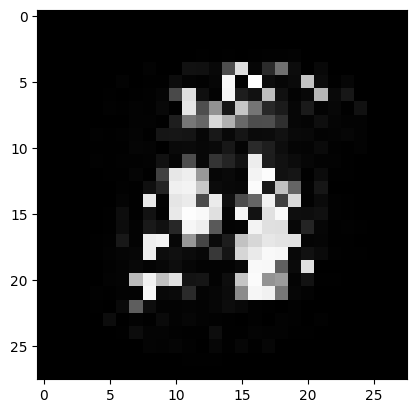

Epoch: 3050
loss_g: 3.722386598587036 	loss_d: 0.08091658353805542
Epoch: 3100
loss_g: 3.929765462875366 	loss_d: 0.04164388030767441
Epoch: 3150
loss_g: 3.742326259613037 	loss_d: 0.10134606808423996
Epoch: 3200
loss_g: 3.8014721870422363 	loss_d: 0.05688517913222313
Epoch: 3250
loss_g: 3.66184401512146 	loss_d: 0.11698582768440247
Epoch: 3300
loss_g: 3.8556675910949707 	loss_d: 0.060349173843860626
Epoch: 3350
loss_g: 4.043047904968262 	loss_d: 0.04408875107765198
Epoch: 3400
loss_g: 4.175426006317139 	loss_d: 0.0374118909239769
Epoch: 3450
loss_g: 3.8748669624328613 	loss_d: 0.08294188976287842
Epoch: 3500
loss_g: 3.7882580757141113 	loss_d: 0.050276730209589005


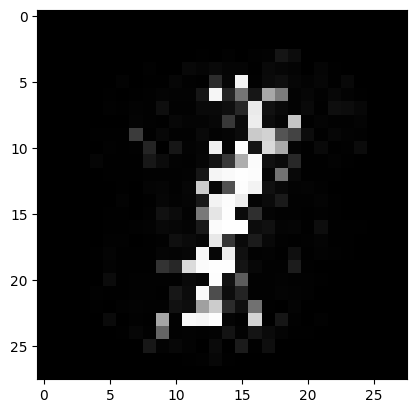

Epoch: 3550
loss_g: 3.696415424346924 	loss_d: 0.05711095407605171
Epoch: 3600
loss_g: 3.6009178161621094 	loss_d: 0.06659640371799469
Epoch: 3650
loss_g: 3.760720729827881 	loss_d: 0.0335921086370945
Epoch: 3700
loss_g: 3.583521842956543 	loss_d: 0.07797271013259888
Epoch: 3750
loss_g: 3.8155839443206787 	loss_d: 0.07437744736671448
Epoch: 3800
loss_g: 3.6278936862945557 	loss_d: 0.05062364786863327
Epoch: 3850
loss_g: 3.5022966861724854 	loss_d: 0.047422342002391815
Epoch: 3900
loss_g: 3.4815356731414795 	loss_d: 0.08516162633895874
Epoch: 3950
loss_g: 3.5098202228546143 	loss_d: 0.13663101196289062
Epoch: 4000
loss_g: 3.645045042037964 	loss_d: 0.09187888354063034


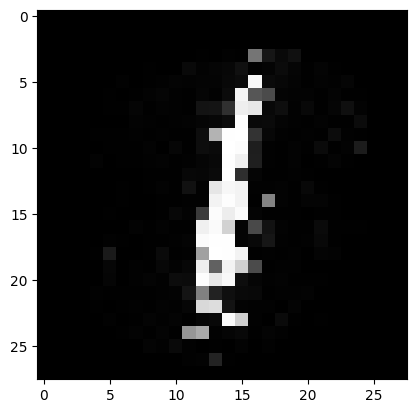

Epoch: 4050
loss_g: 3.8102452754974365 	loss_d: 0.09291195124387741
Epoch: 4100
loss_g: 3.6862947940826416 	loss_d: 0.060355380177497864
Epoch: 4150
loss_g: 3.5722270011901855 	loss_d: 0.06503201276063919
Epoch: 4200
loss_g: 3.5124242305755615 	loss_d: 0.0620223805308342
Epoch: 4250
loss_g: 3.6191537380218506 	loss_d: 0.11720196157693863
Epoch: 4300
loss_g: 3.764256477355957 	loss_d: 0.11441293358802795
Epoch: 4350
loss_g: 3.730705976486206 	loss_d: 0.0676477923989296
Epoch: 4400
loss_g: 3.944096803665161 	loss_d: 0.10988596081733704
Epoch: 4450
loss_g: 4.119767189025879 	loss_d: 0.03915267437696457
Epoch: 4500
loss_g: 4.121697425842285 	loss_d: 0.06187661737203598


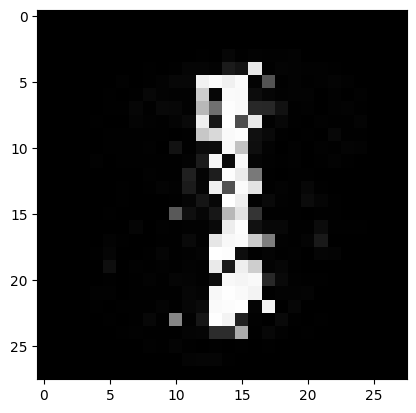

Epoch: 4550
loss_g: 3.9498307704925537 	loss_d: 0.03852463513612747
Epoch: 4600
loss_g: 3.6822447776794434 	loss_d: 0.07402408123016357
Epoch: 4650
loss_g: 3.840460777282715 	loss_d: 0.13289934396743774
Epoch: 4700
loss_g: 3.5911827087402344 	loss_d: 0.07150901108980179
Epoch: 4750
loss_g: 3.583557367324829 	loss_d: 0.04280257225036621
Epoch: 4800
loss_g: 3.5784411430358887 	loss_d: 0.12317705154418945
Epoch: 4850
loss_g: 3.5201127529144287 	loss_d: 0.09756600111722946
Epoch: 4900
loss_g: 3.7586164474487305 	loss_d: 0.10543601214885712
Epoch: 4950
loss_g: 3.563720941543579 	loss_d: 0.08133160322904587
Epoch: 5000
loss_g: 3.7485907077789307 	loss_d: 0.09886565059423447


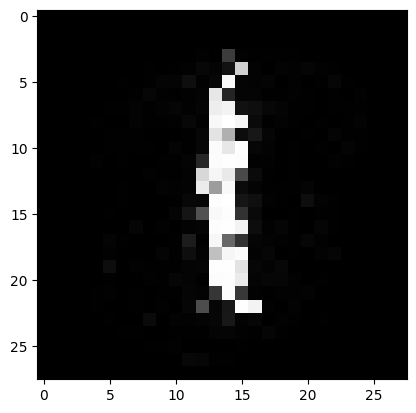

Epoch: 5050
loss_g: 3.92197322845459 	loss_d: 0.0341285765171051
Epoch: 5100
loss_g: 3.945995330810547 	loss_d: 0.09304488450288773
Epoch: 5150
loss_g: 4.036096572875977 	loss_d: 0.09218354523181915
Epoch: 5200
loss_g: 3.8615193367004395 	loss_d: 0.08372289687395096
Epoch: 5250
loss_g: 3.6492366790771484 	loss_d: 0.11095182597637177
Epoch: 5300
loss_g: 3.479994058609009 	loss_d: 0.09613538533449173
Epoch: 5350
loss_g: 3.5564422607421875 	loss_d: 0.15376658737659454
Epoch: 5400
loss_g: 3.680553913116455 	loss_d: 0.15214389562606812
Epoch: 5450
loss_g: 4.061781406402588 	loss_d: 0.02543344534933567
Epoch: 5500
loss_g: 3.886476993560791 	loss_d: 0.04177093133330345


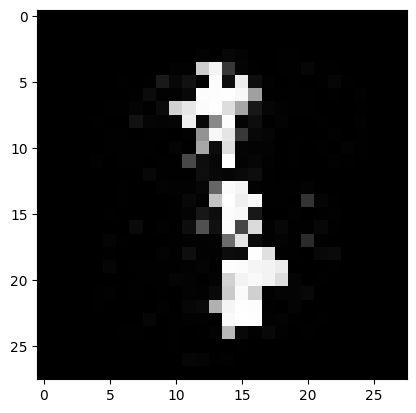

Epoch: 5550
loss_g: 4.188575267791748 	loss_d: 0.028606567531824112
Epoch: 5600
loss_g: 4.202441692352295 	loss_d: 0.0362272635102272
Epoch: 5650
loss_g: 4.062788486480713 	loss_d: 0.06200089305639267
Epoch: 5700
loss_g: 4.105091571807861 	loss_d: 0.06313963234424591
Epoch: 5750
loss_g: 4.163799285888672 	loss_d: 0.02581198327243328
Epoch: 5800
loss_g: 3.924288272857666 	loss_d: 0.051574911922216415
Epoch: 5850
loss_g: 3.7161271572113037 	loss_d: 0.1292768269777298
Epoch: 5900
loss_g: 3.679239511489868 	loss_d: 0.09128350019454956
Epoch: 5950
loss_g: 3.406177282333374 	loss_d: 0.18914876878261566
Epoch: 6000
loss_g: 3.312770366668701 	loss_d: 0.20332592725753784


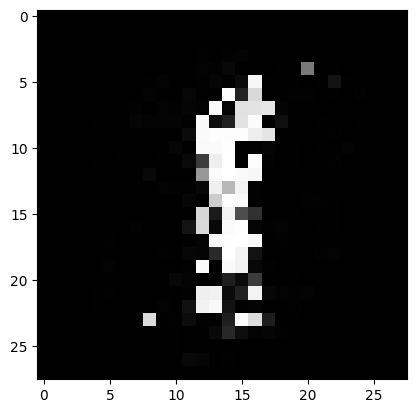

Epoch: 6050
loss_g: 3.609043598175049 	loss_d: 0.18050029873847961
Epoch: 6100
loss_g: 3.4373838901519775 	loss_d: 0.1212214007973671
Epoch: 6150
loss_g: 3.5874791145324707 	loss_d: 0.059605251997709274
Epoch: 6200
loss_g: 3.6173582077026367 	loss_d: 0.09948211908340454
Epoch: 6250
loss_g: 3.399765968322754 	loss_d: 0.05318930000066757
Epoch: 6300
loss_g: 3.5704972743988037 	loss_d: 0.051041945815086365
Epoch: 6350
loss_g: 3.51088285446167 	loss_d: 0.14376796782016754
Epoch: 6400
loss_g: 3.0493109226226807 	loss_d: 0.1126885637640953
Epoch: 6450
loss_g: 3.1771984100341797 	loss_d: 0.1592552810907364
Epoch: 6500
loss_g: 3.305941104888916 	loss_d: 0.09860248863697052


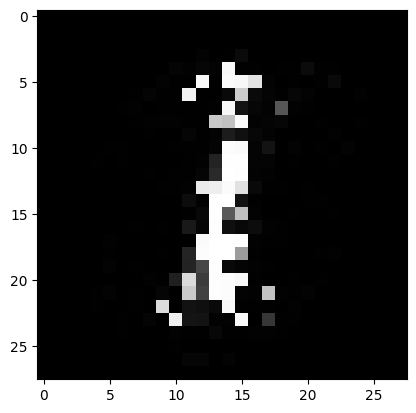

Epoch: 6550
loss_g: 3.349670648574829 	loss_d: 0.07850766181945801
Epoch: 6600
loss_g: 3.5164074897766113 	loss_d: 0.073589026927948
Epoch: 6650
loss_g: 3.49932861328125 	loss_d: 0.08780660480260849
Epoch: 6700
loss_g: 3.1793785095214844 	loss_d: 0.13178133964538574
Epoch: 6750
loss_g: 3.029881477355957 	loss_d: 0.09715297818183899
Epoch: 6800
loss_g: 3.313505172729492 	loss_d: 0.15687817335128784
Epoch: 6850
loss_g: 3.2363951206207275 	loss_d: 0.14128080010414124
Epoch: 6900
loss_g: 3.3820207118988037 	loss_d: 0.2044345587491989
Epoch: 6950
loss_g: 3.4803435802459717 	loss_d: 0.07389917969703674
Epoch: 7000
loss_g: 3.345930337905884 	loss_d: 0.0739661455154419


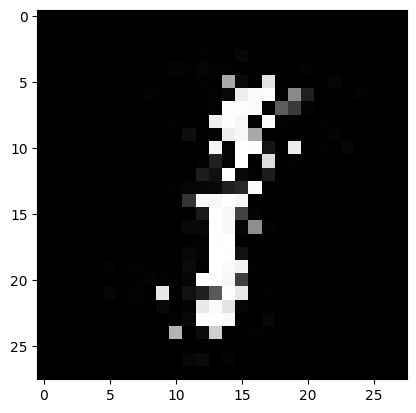

Epoch: 7050
loss_g: 3.501082420349121 	loss_d: 0.04454386606812477
Epoch: 7100
loss_g: 3.5829198360443115 	loss_d: 0.0840323194861412
Epoch: 7150
loss_g: 3.707275867462158 	loss_d: 0.04771755263209343
Epoch: 7200
loss_g: 3.574225425720215 	loss_d: 0.06608401238918304
Epoch: 7250
loss_g: 3.655937433242798 	loss_d: 0.10434927046298981
Epoch: 7300
loss_g: 3.707003116607666 	loss_d: 0.12446597218513489
Epoch: 7350
loss_g: 3.4090445041656494 	loss_d: 0.06519367545843124
Epoch: 7400
loss_g: 3.879952907562256 	loss_d: 0.0807936042547226
Epoch: 7450
loss_g: 3.454080820083618 	loss_d: 0.09090423583984375
Epoch: 7500
loss_g: 3.44476580619812 	loss_d: 0.08304347097873688


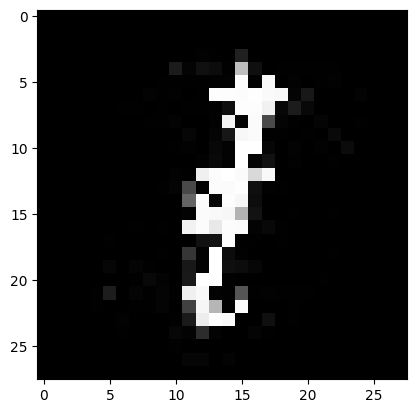

Epoch: 7550
loss_g: 3.25905704498291 	loss_d: 0.09785064309835434
Epoch: 7600
loss_g: 3.489563465118408 	loss_d: 0.13296200335025787
Epoch: 7650
loss_g: 3.4992289543151855 	loss_d: 0.06757049262523651
Epoch: 7700
loss_g: 3.5253214836120605 	loss_d: 0.13888366520404816
Epoch: 7750
loss_g: 3.2354536056518555 	loss_d: 0.12992560863494873
Epoch: 7800
loss_g: 3.598783493041992 	loss_d: 0.10372903943061829
Epoch: 7850
loss_g: 3.4187755584716797 	loss_d: 0.05398260056972504
Epoch: 7900
loss_g: 3.5079774856567383 	loss_d: 0.07070253789424896
Epoch: 7950
loss_g: 3.5120766162872314 	loss_d: 0.10364198684692383
Epoch: 8000
loss_g: 3.5507078170776367 	loss_d: 0.07917366921901703


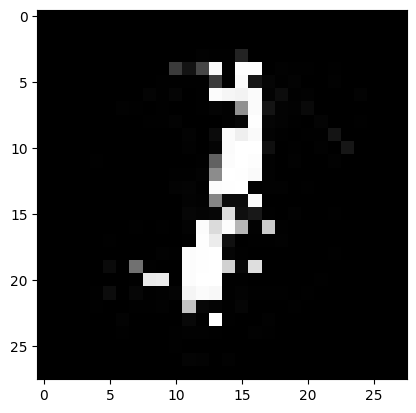

Epoch: 8050
loss_g: 3.5753800868988037 	loss_d: 0.06624922156333923
Epoch: 8100
loss_g: 3.6769442558288574 	loss_d: 0.06113675236701965
Epoch: 8150
loss_g: 3.319585084915161 	loss_d: 0.04134463891386986
Epoch: 8200
loss_g: 3.510927677154541 	loss_d: 0.06837334483861923
Epoch: 8250
loss_g: 3.228078603744507 	loss_d: 0.1826043277978897
Epoch: 8300
loss_g: 3.571614980697632 	loss_d: 0.06588250398635864
Epoch: 8350
loss_g: 3.573986768722534 	loss_d: 0.06285972893238068
Epoch: 8400
loss_g: 3.2031283378601074 	loss_d: 0.08272117376327515
Epoch: 8450
loss_g: 3.1975059509277344 	loss_d: 0.09639154374599457
Epoch: 8500
loss_g: 3.342992067337036 	loss_d: 0.1281251609325409


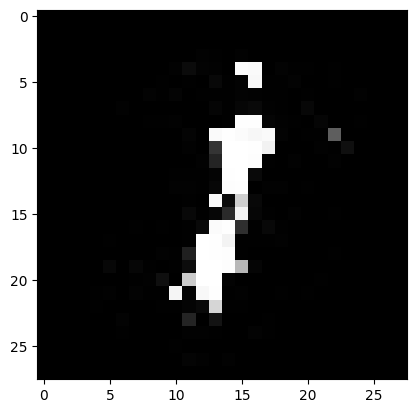

Epoch: 8550
loss_g: 3.4426493644714355 	loss_d: 0.07287280261516571
Epoch: 8600
loss_g: 3.689777135848999 	loss_d: 0.07084238529205322
Epoch: 8650
loss_g: 3.593250036239624 	loss_d: 0.048774510622024536
Epoch: 8700
loss_g: 3.544395685195923 	loss_d: 0.07908304035663605
Epoch: 8750
loss_g: 3.7744908332824707 	loss_d: 0.1372823864221573
Epoch: 8800
loss_g: 3.7880609035491943 	loss_d: 0.0884987860918045
Epoch: 8850
loss_g: 3.6298108100891113 	loss_d: 0.10249003767967224
Epoch: 8900
loss_g: 3.7170815467834473 	loss_d: 0.04705870896577835
Epoch: 8950
loss_g: 3.8996517658233643 	loss_d: 0.06521262228488922
Epoch: 9000
loss_g: 3.458732843399048 	loss_d: 0.10507060587406158


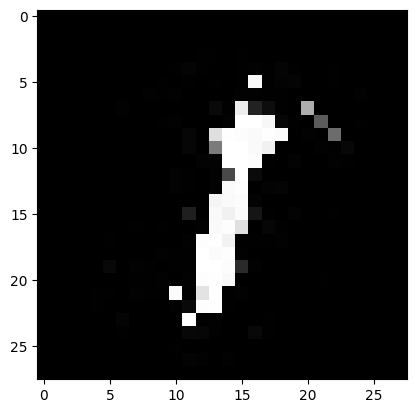

Epoch: 9050
loss_g: 3.5097906589508057 	loss_d: 0.07536906003952026
Epoch: 9100
loss_g: 3.4622557163238525 	loss_d: 0.0907086580991745
Epoch: 9150
loss_g: 3.489619016647339 	loss_d: 0.06230827048420906
Epoch: 9200
loss_g: 3.397099256515503 	loss_d: 0.0675157755613327
Epoch: 9250
loss_g: 3.1726436614990234 	loss_d: 0.1660328507423401
Epoch: 9300
loss_g: 3.0326344966888428 	loss_d: 0.1515350043773651
Epoch: 9350
loss_g: 3.4656243324279785 	loss_d: 0.12016142904758453
Epoch: 9400
loss_g: 3.508579730987549 	loss_d: 0.10655955225229263
Epoch: 9450
loss_g: 3.0687713623046875 	loss_d: 0.06862162798643112
Epoch: 9500
loss_g: 2.9453108310699463 	loss_d: 0.15099209547042847


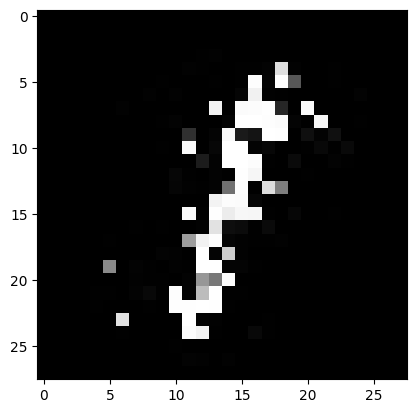

Epoch: 9550
loss_g: 3.046706199645996 	loss_d: 0.07923362404108047
Epoch: 9600
loss_g: 3.13378643989563 	loss_d: 0.1359405666589737
Epoch: 9650
loss_g: 3.265249013900757 	loss_d: 0.2255871742963791
Epoch: 9700
loss_g: 3.1628289222717285 	loss_d: 0.14832299947738647
Epoch: 9750
loss_g: 3.473965644836426 	loss_d: 0.04568200930953026
Epoch: 9800
loss_g: 3.1804330348968506 	loss_d: 0.07949862629175186
Epoch: 9850
loss_g: 3.2232818603515625 	loss_d: 0.10758026689291
Epoch: 9900
loss_g: 3.3727855682373047 	loss_d: 0.16693651676177979
Epoch: 9950
loss_g: 3.2677268981933594 	loss_d: 0.11158792674541473
Epoch: 10000
loss_g: 3.168997049331665 	loss_d: 0.13904643058776855


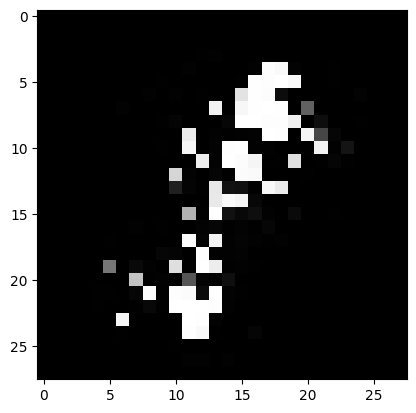

Epoch: 10050
loss_g: 3.0830328464508057 	loss_d: 0.09906231611967087
Epoch: 10100
loss_g: 3.2895452976226807 	loss_d: 0.1300988495349884
Epoch: 10150
loss_g: 3.241389751434326 	loss_d: 0.1879691332578659
Epoch: 10200
loss_g: 3.3772377967834473 	loss_d: 0.10458196699619293
Epoch: 10250
loss_g: 2.9323136806488037 	loss_d: 0.1175338476896286
Epoch: 10300
loss_g: 3.0022289752960205 	loss_d: 0.12887905538082123
Epoch: 10350
loss_g: 3.1824183464050293 	loss_d: 0.1315702497959137
Epoch: 10400
loss_g: 3.1780357360839844 	loss_d: 0.09396085143089294
Epoch: 10450
loss_g: 3.2040586471557617 	loss_d: 0.06758997589349747
Epoch: 10500
loss_g: 3.023106336593628 	loss_d: 0.11848009377717972


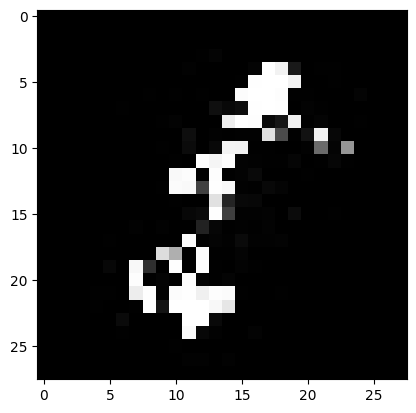

Epoch: 10550
loss_g: 2.8240184783935547 	loss_d: 0.10719011723995209
Epoch: 10600
loss_g: 2.960441827774048 	loss_d: 0.11319930106401443
Epoch: 10650
loss_g: 3.093820095062256 	loss_d: 0.1637994945049286
Epoch: 10700
loss_g: 3.306460380554199 	loss_d: 0.11294472217559814
Epoch: 10750
loss_g: 2.8864834308624268 	loss_d: 0.1392279863357544
Epoch: 10800
loss_g: 3.3577067852020264 	loss_d: 0.12234555184841156
Epoch: 10850
loss_g: 3.4555130004882812 	loss_d: 0.06684451550245285
Epoch: 10900
loss_g: 3.418654203414917 	loss_d: 0.08557666838169098
Epoch: 10950
loss_g: 3.2692341804504395 	loss_d: 0.08604660630226135
Epoch: 11000
loss_g: 3.407849073410034 	loss_d: 0.07216091454029083


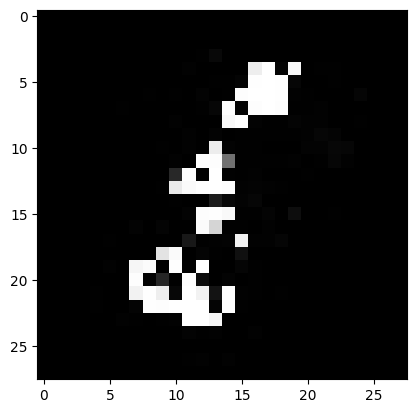

Epoch: 11050
loss_g: 3.629941701889038 	loss_d: 0.037098608911037445
Epoch: 11100
loss_g: 3.725787878036499 	loss_d: 0.05328934267163277
Epoch: 11150
loss_g: 3.9162375926971436 	loss_d: 0.06746344268321991
Epoch: 11200
loss_g: 4.022329807281494 	loss_d: 0.05600670725107193
Epoch: 11250
loss_g: 3.988597869873047 	loss_d: 0.039556726813316345
Epoch: 11300
loss_g: 3.929995536804199 	loss_d: 0.03728906065225601
Epoch: 11350
loss_g: 3.3411059379577637 	loss_d: 0.07545046508312225
Epoch: 11400
loss_g: 3.541947364807129 	loss_d: 0.0772712305188179
Epoch: 11450
loss_g: 3.2923710346221924 	loss_d: 0.08266131579875946
Epoch: 11500
loss_g: 3.16511869430542 	loss_d: 0.07649901509284973


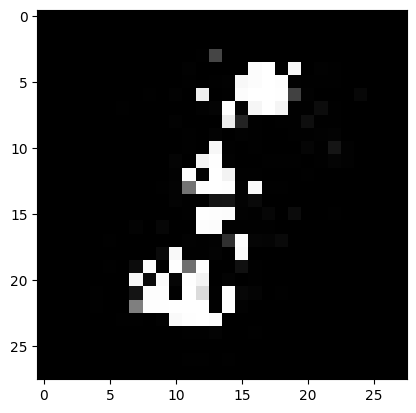

Epoch: 11550
loss_g: 3.245373249053955 	loss_d: 0.08462159335613251
Epoch: 11600
loss_g: 3.4748218059539795 	loss_d: 0.09033980965614319
Epoch: 11650
loss_g: 3.4180521965026855 	loss_d: 0.05130191892385483
Epoch: 11700
loss_g: 3.276216983795166 	loss_d: 0.08290697634220123
Epoch: 11750
loss_g: 3.0857841968536377 	loss_d: 0.08462800085544586
Epoch: 11800
loss_g: 3.1357195377349854 	loss_d: 0.08987639844417572
Epoch: 11850
loss_g: 3.1366124153137207 	loss_d: 0.07820076495409012
Epoch: 11900
loss_g: 3.351576089859009 	loss_d: 0.07711456716060638
Epoch: 11950
loss_g: 3.29227352142334 	loss_d: 0.08665858209133148
Epoch: 12000
loss_g: 3.0243844985961914 	loss_d: 0.11032421886920929


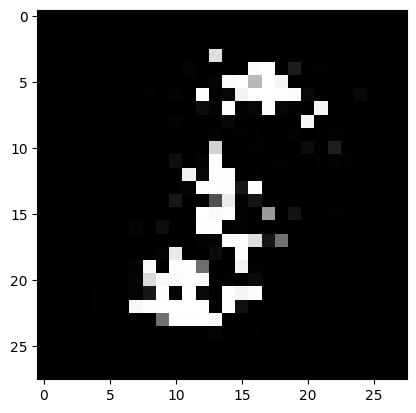

Epoch: 12050
loss_g: 3.034759998321533 	loss_d: 0.0671338140964508
Epoch: 12100
loss_g: 2.90350341796875 	loss_d: 0.14366285502910614
Epoch: 12150
loss_g: 2.659074306488037 	loss_d: 0.11633032560348511
Epoch: 12200
loss_g: 2.840749979019165 	loss_d: 0.11391207575798035
Epoch: 12250
loss_g: 2.821282386779785 	loss_d: 0.17545276880264282
Epoch: 12300
loss_g: 3.0080370903015137 	loss_d: 0.1480424553155899
Epoch: 12350
loss_g: 2.9760992527008057 	loss_d: 0.12825022637844086
Epoch: 12400
loss_g: 3.029785394668579 	loss_d: 0.15213418006896973
Epoch: 12450
loss_g: 3.3180952072143555 	loss_d: 0.12571431696414948
Epoch: 12500
loss_g: 3.4538979530334473 	loss_d: 0.14648208022117615


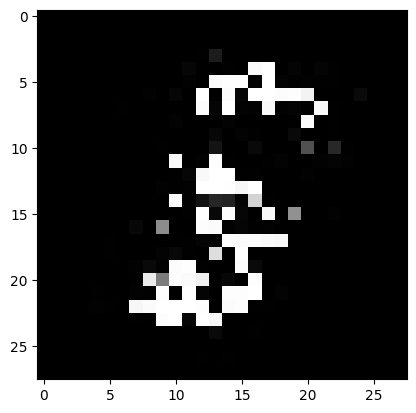

Epoch: 12550
loss_g: 3.493302583694458 	loss_d: 0.1268620491027832
Epoch: 12600
loss_g: 3.3845434188842773 	loss_d: 0.08411352336406708
Epoch: 12650
loss_g: 3.445955991744995 	loss_d: 0.08496486395597458
Epoch: 12700
loss_g: 3.0650908946990967 	loss_d: 0.07902555167675018
Epoch: 12750
loss_g: 2.691314220428467 	loss_d: 0.17936351895332336
Epoch: 12800
loss_g: 2.6255767345428467 	loss_d: 0.12233595550060272
Epoch: 12850
loss_g: 2.486013650894165 	loss_d: 0.16388919949531555
Epoch: 12900
loss_g: 2.739190101623535 	loss_d: 0.12948952615261078
Epoch: 12950
loss_g: 3.060065507888794 	loss_d: 0.14536909759044647
Epoch: 13000
loss_g: 3.074483633041382 	loss_d: 0.11081358790397644


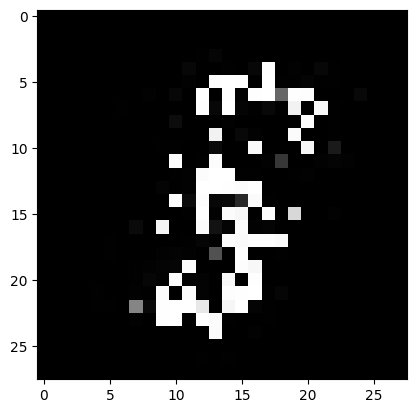

Epoch: 13050
loss_g: 3.005815267562866 	loss_d: 0.13513126969337463
Epoch: 13100
loss_g: 3.041090726852417 	loss_d: 0.12178321182727814
Epoch: 13150
loss_g: 3.067142963409424 	loss_d: 0.10258150845766068
Epoch: 13200
loss_g: 3.227313756942749 	loss_d: 0.2124459594488144
Epoch: 13250
loss_g: 3.161787748336792 	loss_d: 0.11963161081075668
Epoch: 13300
loss_g: 2.939486026763916 	loss_d: 0.09908489882946014
Epoch: 13350
loss_g: 2.534133195877075 	loss_d: 0.15602579712867737
Epoch: 13400
loss_g: 2.4620554447174072 	loss_d: 0.17193114757537842
Epoch: 13450
loss_g: 2.7916653156280518 	loss_d: 0.23821140825748444
Epoch: 13500
loss_g: 2.8978917598724365 	loss_d: 0.12158197164535522


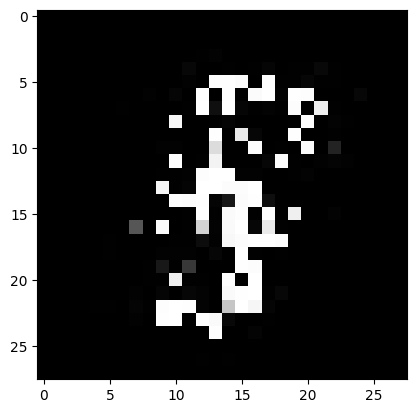

Epoch: 13550
loss_g: 3.021801471710205 	loss_d: 0.15541526675224304
Epoch: 13600
loss_g: 2.8728582859039307 	loss_d: 0.1986786276102066
Epoch: 13650
loss_g: 2.763787269592285 	loss_d: 0.10199090093374252
Epoch: 13700
loss_g: 2.814948081970215 	loss_d: 0.10014192759990692
Epoch: 13750
loss_g: 2.870319128036499 	loss_d: 0.2050696611404419
Epoch: 13800
loss_g: 2.550291061401367 	loss_d: 0.19651490449905396
Epoch: 13850
loss_g: 2.5372958183288574 	loss_d: 0.17851102352142334
Epoch: 13900
loss_g: 2.478456974029541 	loss_d: 0.11953286826610565
Epoch: 13950
loss_g: 2.607131242752075 	loss_d: 0.2163850963115692
Epoch: 14000
loss_g: 2.7639718055725098 	loss_d: 0.12550188601016998


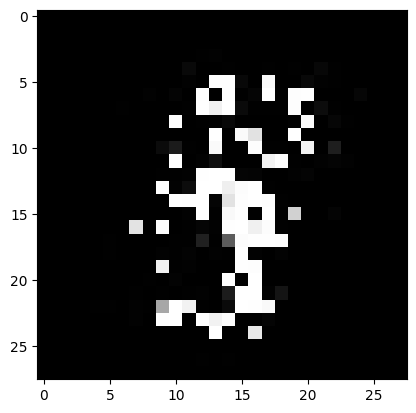

Epoch: 14050
loss_g: 2.7633426189422607 	loss_d: 0.1416666954755783
Epoch: 14100
loss_g: 2.5189807415008545 	loss_d: 0.26462146639823914
Epoch: 14150
loss_g: 2.442727565765381 	loss_d: 0.1399800032377243
Epoch: 14200
loss_g: 2.4918715953826904 	loss_d: 0.2309865653514862
Epoch: 14250
loss_g: 2.8161163330078125 	loss_d: 0.1674736887216568
Epoch: 14300
loss_g: 3.0076916217803955 	loss_d: 0.1051180362701416
Epoch: 14350
loss_g: 2.8662359714508057 	loss_d: 0.16204547882080078
Epoch: 14400
loss_g: 2.448220729827881 	loss_d: 0.2568112909793854
Epoch: 14450
loss_g: 2.6459927558898926 	loss_d: 0.14242056012153625
Epoch: 14500
loss_g: 2.7918896675109863 	loss_d: 0.1186770349740982


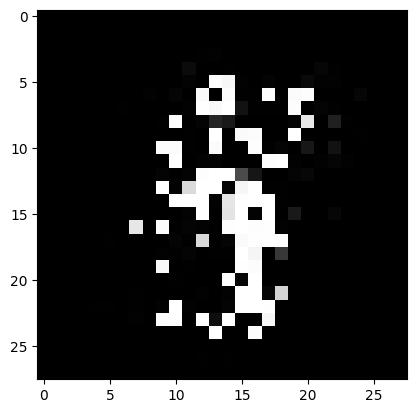

Epoch: 14550
loss_g: 2.5151870250701904 	loss_d: 0.129943385720253
Epoch: 14600
loss_g: 2.5898776054382324 	loss_d: 0.15146604180335999
Epoch: 14650
loss_g: 2.7145707607269287 	loss_d: 0.21492430567741394
Epoch: 14700
loss_g: 2.8545596599578857 	loss_d: 0.1840580403804779
Epoch: 14750
loss_g: 2.585433006286621 	loss_d: 0.1765362024307251
Epoch: 14800
loss_g: 2.2142868041992188 	loss_d: 0.28677040338516235
Epoch: 14850
loss_g: 2.111393690109253 	loss_d: 0.24576690793037415
Epoch: 14900
loss_g: 2.175638437271118 	loss_d: 0.3723837435245514
Epoch: 14950
loss_g: 2.4110188484191895 	loss_d: 0.23870894312858582
Epoch: 15000
loss_g: 2.4232728481292725 	loss_d: 0.2729586958885193


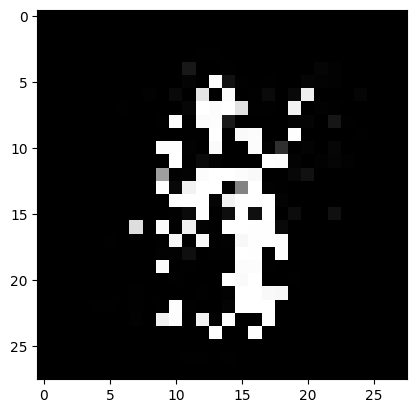

Epoch: 15050
loss_g: 2.368112087249756 	loss_d: 0.1645888090133667
Epoch: 15100
loss_g: 2.224862813949585 	loss_d: 0.1668011099100113
Epoch: 15150
loss_g: 2.03558349609375 	loss_d: 0.3388591408729553
Epoch: 15200
loss_g: 2.0270397663116455 	loss_d: 0.3096776008605957
Epoch: 15250
loss_g: 2.030158758163452 	loss_d: 0.340042382478714
Epoch: 15300
loss_g: 2.0492780208587646 	loss_d: 0.26061639189720154
Epoch: 15350
loss_g: 2.1594207286834717 	loss_d: 0.29165297746658325
Epoch: 15400
loss_g: 1.840846061706543 	loss_d: 0.2794865369796753
Epoch: 15450
loss_g: 2.0301930904388428 	loss_d: 0.4493885636329651
Epoch: 15500
loss_g: 2.3183376789093018 	loss_d: 0.21969160437583923


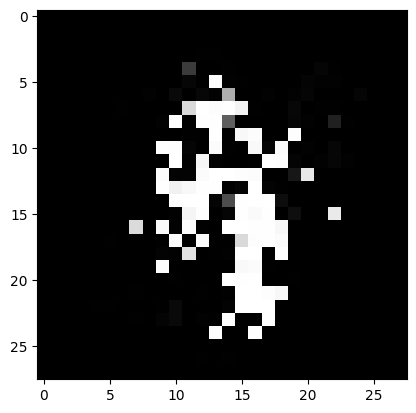

Epoch: 15550
loss_g: 2.418649911880493 	loss_d: 0.2710477411746979
Epoch: 15600
loss_g: 2.4220566749572754 	loss_d: 0.23348283767700195
Epoch: 15650
loss_g: 2.4471466541290283 	loss_d: 0.28721755743026733
Epoch: 15700
loss_g: 2.4594802856445312 	loss_d: 0.21680092811584473
Epoch: 15750
loss_g: 2.607856035232544 	loss_d: 0.1721937656402588
Epoch: 15800
loss_g: 2.741400957107544 	loss_d: 0.19376331567764282
Epoch: 15850
loss_g: 2.7564282417297363 	loss_d: 0.2959679365158081
Epoch: 15900
loss_g: 2.6528267860412598 	loss_d: 0.16623365879058838
Epoch: 15950
loss_g: 2.7254106998443604 	loss_d: 0.2712721824645996
Epoch: 16000
loss_g: 2.744978666305542 	loss_d: 0.2404710054397583


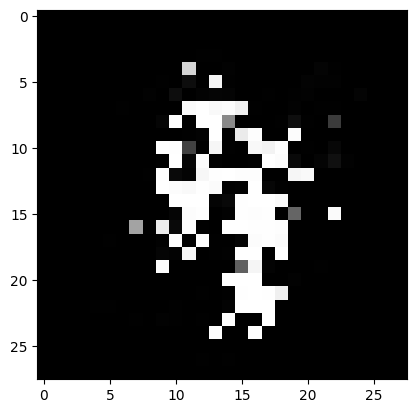

Epoch: 16050
loss_g: 2.764116048812866 	loss_d: 0.09282458573579788
Epoch: 16100
loss_g: 2.7703208923339844 	loss_d: 0.1531619131565094
Epoch: 16150
loss_g: 2.7657744884490967 	loss_d: 0.24282991886138916
Epoch: 16200
loss_g: 2.6661412715911865 	loss_d: 0.2209116816520691
Epoch: 16250
loss_g: 2.334277391433716 	loss_d: 0.27263981103897095
Epoch: 16300
loss_g: 1.7572590112686157 	loss_d: 0.297446608543396
Epoch: 16350
loss_g: 1.484475016593933 	loss_d: 0.4238404929637909
Epoch: 16400
loss_g: 1.5493258237838745 	loss_d: 0.3440810441970825
Epoch: 16450
loss_g: 1.5382936000823975 	loss_d: 0.36669921875
Epoch: 16500
loss_g: 1.674835443496704 	loss_d: 0.492409884929657


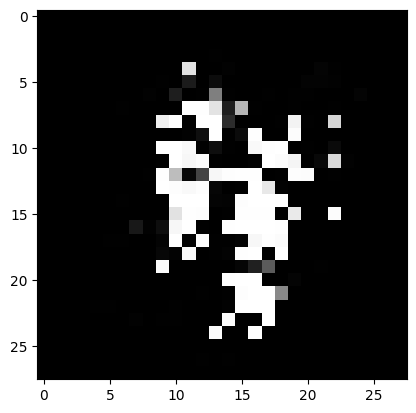

Epoch: 16550
loss_g: 1.782737374305725 	loss_d: 0.26941248774528503
Epoch: 16600
loss_g: 1.985691785812378 	loss_d: 0.3675704300403595
Epoch: 16650
loss_g: 2.020728349685669 	loss_d: 0.3244544267654419
Epoch: 16700
loss_g: 1.8892347812652588 	loss_d: 0.26167699694633484
Epoch: 16750
loss_g: 2.075667142868042 	loss_d: 0.35307183861732483
Epoch: 16800
loss_g: 2.2914493083953857 	loss_d: 0.38283637166023254
Epoch: 16850
loss_g: 2.432966470718384 	loss_d: 0.2559611201286316
Epoch: 16900
loss_g: 2.5064287185668945 	loss_d: 0.19585630297660828
Epoch: 16950
loss_g: 2.3615450859069824 	loss_d: 0.17959661781787872
Epoch: 17000
loss_g: 2.028311014175415 	loss_d: 0.3355649709701538


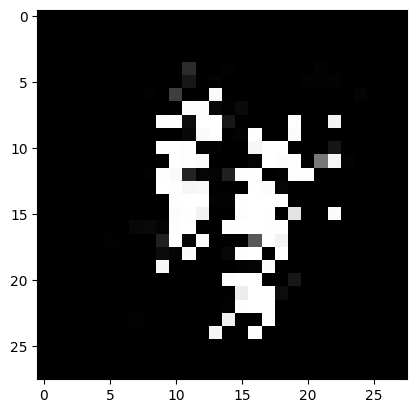

Epoch: 17050
loss_g: 1.9932159185409546 	loss_d: 0.392084538936615
Epoch: 17100
loss_g: 1.7891764640808105 	loss_d: 0.46864378452301025
Epoch: 17150
loss_g: 1.573941946029663 	loss_d: 0.5181424617767334
Epoch: 17200
loss_g: 1.470866322517395 	loss_d: 0.5808993577957153
Epoch: 17250
loss_g: 1.5219535827636719 	loss_d: 0.4685553312301636
Epoch: 17300
loss_g: 1.6901155710220337 	loss_d: 0.5336030721664429
Epoch: 17350
loss_g: 1.7906161546707153 	loss_d: 0.41481566429138184
Epoch: 17400
loss_g: 1.80576753616333 	loss_d: 0.5725235939025879
Epoch: 17450
loss_g: 1.7545058727264404 	loss_d: 0.4195975959300995
Epoch: 17500
loss_g: 1.7628225088119507 	loss_d: 0.41849130392074585


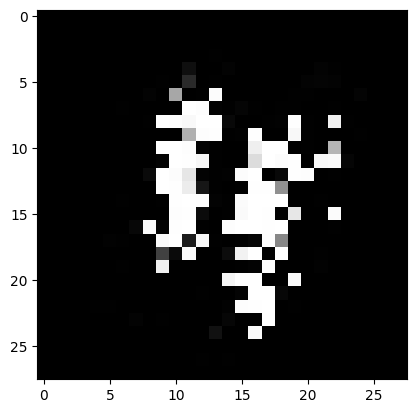

Epoch: 17550
loss_g: 1.8311327695846558 	loss_d: 0.5644186735153198
Epoch: 17600
loss_g: 1.908871054649353 	loss_d: 0.46394604444503784
Epoch: 17650
loss_g: 1.7169272899627686 	loss_d: 0.5288799405097961
Epoch: 17700
loss_g: 1.376631498336792 	loss_d: 0.49122053384780884
Epoch: 17750
loss_g: 1.3994377851486206 	loss_d: 0.5505088567733765
Epoch: 17800
loss_g: 1.6063216924667358 	loss_d: 0.48394280672073364
Epoch: 17850
loss_g: 1.7339071035385132 	loss_d: 0.6952450275421143
Epoch: 17900
loss_g: 1.7653766870498657 	loss_d: 0.43966689705848694
Epoch: 17950
loss_g: 1.8359603881835938 	loss_d: 0.46579766273498535
Epoch: 18000
loss_g: 1.9225915670394897 	loss_d: 0.3146006166934967


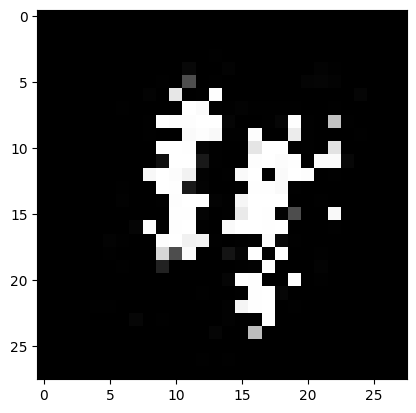

Epoch: 18050
loss_g: 1.949146032333374 	loss_d: 0.4889155626296997
Epoch: 18100
loss_g: 1.901431679725647 	loss_d: 0.4386979937553406
Epoch: 18150
loss_g: 1.8575795888900757 	loss_d: 0.38516953587532043
Epoch: 18200
loss_g: 1.6519405841827393 	loss_d: 0.4682411551475525
Epoch: 18250
loss_g: 1.4958279132843018 	loss_d: 0.5784175395965576
Epoch: 18300
loss_g: 1.4246169328689575 	loss_d: 0.5453110933303833
Epoch: 18350
loss_g: 1.518082857131958 	loss_d: 0.6222577691078186
Epoch: 18400
loss_g: 1.5941094160079956 	loss_d: 0.6546910405158997
Epoch: 18450
loss_g: 1.5468511581420898 	loss_d: 0.406462162733078
Epoch: 18500
loss_g: 1.4509187936782837 	loss_d: 0.582908034324646


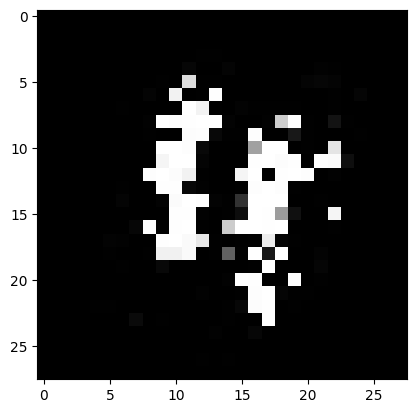

Epoch: 18550
loss_g: 1.4615974426269531 	loss_d: 0.609411358833313
Epoch: 18600
loss_g: 1.4844801425933838 	loss_d: 0.6551609635353088
Epoch: 18650
loss_g: 1.5058999061584473 	loss_d: 0.6789268255233765
Epoch: 18700
loss_g: 1.603386640548706 	loss_d: 0.6038069725036621
Epoch: 18750
loss_g: 1.691709280014038 	loss_d: 0.5707810521125793
Epoch: 18800
loss_g: 1.7372455596923828 	loss_d: 0.46166062355041504
Epoch: 18850
loss_g: 1.7352389097213745 	loss_d: 0.3976268172264099
Epoch: 18900
loss_g: 1.7583849430084229 	loss_d: 0.5582852959632874
Epoch: 18950
loss_g: 1.8069219589233398 	loss_d: 0.4566681981086731
Epoch: 19000
loss_g: 1.824532389640808 	loss_d: 0.37396129965782166


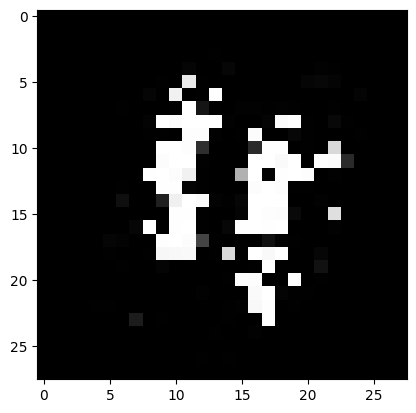

Epoch: 19050
loss_g: 1.683878779411316 	loss_d: 0.4367271661758423
Epoch: 19100
loss_g: 1.4614723920822144 	loss_d: 0.4434039294719696
Epoch: 19150
loss_g: 1.444777488708496 	loss_d: 0.603263258934021
Epoch: 19200
loss_g: 1.4929238557815552 	loss_d: 0.6416193246841431
Epoch: 19250
loss_g: 1.5027261972427368 	loss_d: 0.574442982673645
Epoch: 19300
loss_g: 1.484826683998108 	loss_d: 0.46304577589035034
Epoch: 19350
loss_g: 1.4659298658370972 	loss_d: 0.5136351585388184
Epoch: 19400
loss_g: 1.4025251865386963 	loss_d: 0.6196013689041138
Epoch: 19450
loss_g: 1.3138936758041382 	loss_d: 0.8038392663002014
Epoch: 19500
loss_g: 1.2998381853103638 	loss_d: 0.7270479202270508


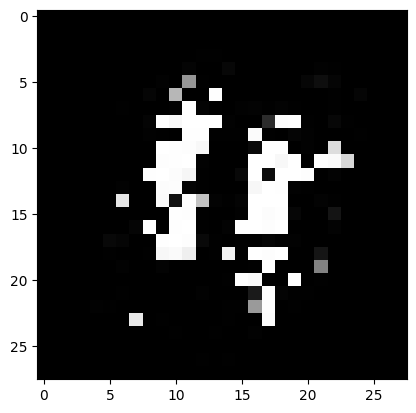

Epoch: 19550
loss_g: 1.2145867347717285 	loss_d: 0.8018838167190552
Epoch: 19600
loss_g: 1.1207298040390015 	loss_d: 0.7529016137123108
Epoch: 19650
loss_g: 1.138197898864746 	loss_d: 0.7562457323074341
Epoch: 19700
loss_g: 1.1231735944747925 	loss_d: 0.834076464176178
Epoch: 19750
loss_g: 1.1680907011032104 	loss_d: 0.6854487657546997
Epoch: 19800
loss_g: 1.286126971244812 	loss_d: 0.9061352014541626
Epoch: 19850
loss_g: 1.3737884759902954 	loss_d: 0.7070126533508301
Epoch: 19900
loss_g: 1.4233782291412354 	loss_d: 0.7703722715377808
Epoch: 19950
loss_g: 1.4436476230621338 	loss_d: 0.858113169670105


In [5]:
lr = 0.01
k = 5
epochs = 20000

generator = Generator().to(device)
disciminator = Discriminator().to(device)

optimizer_gen = torch.optim.SGD(generator.parameters(), lr=lr)
optimizer_dis = torch.optim.SGD(disciminator.parameters(), lr=lr)

criterion_gen = torch.nn.BCEWithLogitsLoss()
criterion_dis = torch.nn.BCEWithLogitsLoss()

scheduler_gen = torch.optim.lr_scheduler.StepLR(optimizer_gen, step_size=25, gamma=0.998)
scheduler_dis = torch.optim.lr_scheduler.StepLR(optimizer_dis, step_size=25, gamma=0.998)

train_models(disciminator, criterion_dis, optimizer_dis, scheduler_dis, generator, criterion_gen, optimizer_gen, scheduler_gen, epochs, train_loader, k, batch_size)